<font size="+3" color=blue><b> <center><u>LEGO - Minifigures Classification For Beginner</u></center></b></font>

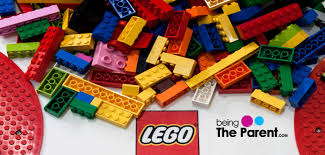

# Objective

The aim of this kernel is to provide all the tips and tricks required to LEGO CLASSIFICATION model on Given image dataset in a single page.This kernel will hold almost all steps and steps required to implement image classification algorithm using SOTA such as ResNET on given Dataset.It could be a great time saver for you.Just utilize it anytime when you are working on Image Classification.

I have learned them from [FastAI](https://docs.fast.ai/)

<font size="+1" color=red ><b>Please Upvote my kernel and keep it in your favourite section if you think it is helpful.</b></font>

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of content</h3>

<font color="blue" size=+1><b>Introduction</b></font>
* [1. What is CNN ?](#2)
* [2. What is Transfer Learning ?](#3)    

<font color="blue" size=+1><b>Library</b></font>
* [1. Installation](#4)
* [2. Import Libraries ](#5)
    
<font color="blue" size=+1><b> Load and view your data </b></font>
* [1. Setting up path for training data ](#6)
* [2. Data Loading For training ](#7)
* [3. Data Explorations ](#8)
* [4. Print Classes present in the data ](#9)

<font color="blue" size=+1><b> Create and train a model </b></font>
* [1. Create Models ](#10)
* [2. Train Model ](#11)
* [3. Finding LR ](#12)
* [4. Finetuning HyperParameter](#13)

<font color="blue" size=+1><b> Others </b></font>
* [1. Interpret the results](#14)
* [2. Prediction Using Trained Model](#15)
* [3. Save and Load Model](#16)
* [4. Sources](#17)

<a id="1"></a>
<font color="blue" size=+2.5><b>Introduction</b></font>


<a id="2"></a>
<font color="blue" size=+2.5><b>1.2  What is CNN ?</b></font>
<br/>
<br/>
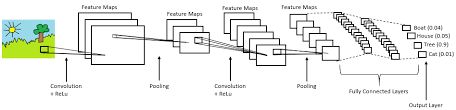
**CNN stands for Convolutional Neural Network which is a specialized neural network for processing data that has an input shape like a 2D matrix like images. CNN's are typically used for image detection and classification.**

<a id="3"></a>
<font color="blue" size=+2.5><b>1.3  What is Transfer Learning ?</b></font>
<br/>
<br/>
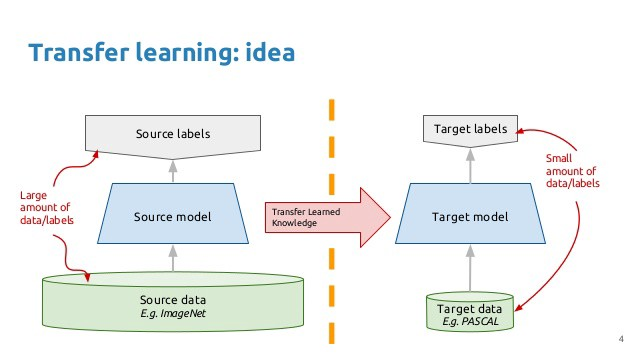
**Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.**

<a id="5"></a>


<font color="blue" size=+2.5><b>2. Library</b></font>

<a id="4"></a>
<font color="blue" size=+2.5><b>2.1 Installation</b></font>
* Numpy
* Pandas
* Matplotlib
* Fastai

<a id="5"></a>
<font color="blue" size=+2.5><b>2.2 Library Import</b></font>

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai==2.0.9

In [ ]:
import random, os
import numpy as np
import torch
from fastai.vision.all import *

<a id="6"></a>
<font color="blue" size=+2.5><b>3.1 Setting up path for training data</b></font>

**Point to be Noted: Number of elements in a list of path is same as number of classes you have**

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
path = Path('/kaggle/input/lego-minifigures-classification/')
lego_data = pd.read_csv(path/'index.csv', index_col=0);lego_data.head()
lego_metadata = pd.read_csv(path/'metadata.csv', index_col=0); lego_metadata.head()
df_lego = pd.merge(lego_data, lego_metadata[['class_id', 'minifigure_name']], on='class_id')
df_lego['labels'] = df_lego['minifigure_name'].apply(lambda x: x.lower())
df_lego['is_valid'] = df_lego['train-valid'].apply(lambda x:x=='train')
df_lego['fname'] = df_lego['path']; df_lego.head()

<a id="7"></a>
<font color="blue" size=+2.5><b>3.2 Data Loading For training</b></font>
<br/>

**Things to be remember:**
* Decide validation percentage ( 0.2 => 20% )
* Provide path for training data
* [Decide augmentations criteria (optional)](https://www.kaggle.com/init27/introduction-to-image-augmentation-using-fastai/)
* Decide image size (which is 224 in my case)
* Test data can also be added but it's optional

In [ ]:
data = ImageDataLoaders.from_df(df_lego, path, valid_pct=0.10,
                                   item_tfms=Resize(412),
                                   bs=10, num_workers=4, valid_col='is_valid', label_col="labels")

<a id="8"></a>
<font color="blue" size=+2.5><b>3.3 Data Explorations</b></font>
<br/>

*Our image dataset is stored as .jpg files in 2 different folders, with each folder bearing the name of model of the images contained in the folder. We use the ImageDataBunch.from_folder() function to load the images and assign labels the images based on the name of the folder they’re read from.*

In [ ]:
data.show_batch()


<a id="9"></a>
<font color="blue" size=+2.5><b>3.4 Print Classes present in the data</b></font>
<br/>

* data.c — How many classes are there in our dataset?
* len(data.train_ds) — What is the size of our training dataset?
* len(data.valid_ds) — What is the size of our validation dataset?

In [ ]:
data

<a id="10"></a>
<font color="blue" size=+2.5><b>4.1 Create Model</b></font>
<br/>
* We now use a pre-trained ResNet50 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.
* Why Transfer learning? Because with transfer learning, you begin with an existing (trained) neural network used for image recognition — and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we’re going to need at least a million images.
* In our case, we have approximately 4000+ images in our training set — you have one guess to decide if that would have been enough if were to train a neural net from scratch.
* We use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [ ]:
learn = cnn_learner(data, resnet152, metrics=[error_rate, accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

<a id="11"></a>
<font color="blue" size=+2.5><b>4.2 Finding LR</b></font>
<br/>

In [ ]:
learn.lr_find()

<a id="12"></a>
<font color="blue" size=+2.5><b>4.3 Train Model</b></font>
<br/>

In [ ]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(100,slice(lr1,lr2),cbs=EarlyStoppingCallback(patience=2))

In [ ]:
# lr1 = 1e-3
lr = 1e-1
learn.fit_one_cycle(200,slice(lr),cbs=EarlyStoppingCallback(patience=2))

<a id="13"></a>
<font color="blue" size=+2.5><b>4.4 Hyper Parameter Tuning</b></font>
<br/>

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(100,slice(1e-1),cbs=EarlyStoppingCallback(patience=3))

<a id="14"></a>
<font color="blue" size=+2.5><b>5.1 Interpret the results</b></font>
<br/>

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

<a id="16"></a>
<font color="blue" size=+2.5><b>5.3 Save and Load Model</b></font>
<br/>


In [ ]:
learn.export()
learn.model_dir = "/kaggle/working"
learn.save("stage-1")

<a id="17"></a>
<font color="blue" size=+2.5><b>5.4 Sources</b></font>
<br/>
* [Fastai MOOC](https://course.fast.ai/)
* [Fastai library](https://docs.fast.ai/)

<a id="18"></a>
<font color="blue" size=+2.5><b>Feedback and Support</b></font>
<br/>
* Your feedback is much appreciated
* Please UPVOTE if you LIKE this notebook
* Comment if you have any doubts or you found any errors in the notebook